<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/ensemble/pytorch_supervised_ensemble_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os
import math
import torch as tf

## Hyper parameters

In [2]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================
# determine optimal hyper-parameters to obtain best testing performance
number_epoch    = 1500
size_minibatch  = 128
learning_rate   = 0.01
alpha = 1
warmup = 100
# ==================================================

In [3]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'

import sys
sys.path.append('/content/drive/MyDrive/HAR/')
import wisdm_1_1
import wisdm_2_0
origianl_x, original_y, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
#origianl_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


x_train.shape :  (14423, 200, 3) y_train.shape:  (14423, 6)


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(origianl_x, original_y, random_state=42, stratify=original_y, test_size=0.2)

## Costumize dataloader for pytorch

In [5]:
class dataset (Dataset):
    def  __init__(self, data, label):

        self.data    = data
        self.label    = label
            
    def __getitem__(self, index):

        data    = self.data[index]
        label   = self.label[index]
        return (data, label)

    def __len__(self):
        return self.data.shape[0]

## Construct datasets and dataloaders for training and testing

In [6]:
## transformer를 통과하기 위해 데이터 shape 변경
# x_train = x_train.reshape(-1, x_train.shape[2], x_train.shape[1])
# x_test = x_test.reshape(-1, x_test.shape[2], x_test.shape[1])
x_train = tf.FloatTensor(x_train)
x_test = tf.FloatTensor(x_test)
x_train = x_train.permute(0, 2, 1)
x_test = x_test.permute(0, 2, 1)

dataset_train = dataset(x_train, y_train) 
dataset_test  = dataset(x_test, y_test) 

dataloader_train = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, num_workers=2)
dataloader_test  = DataLoader(dataset_test,  batch_size=size_minibatch, shuffle=False, drop_last=True, num_workers=2) 

## Class for the neural network

In [7]:
class Classifier(nn.Module):
    def __init__(self, dim, channel, num_classes, is_alone=False):
        super(Classifier, self).__init__()
        
        if is_alone:
            self.dim = dim
            self.channel = channel
            self.num_classes = num_classes
        else:
            self.dim = dim
            self.channel = channel
            self.num_classes = num_classes

        # original inputs shape : [batch_size, channel, dim]
        # classifier inputs shape : [batch_size, channel*80, dim//8]

        self.conv1 = nn.Conv1d(self.channel, 512, kernel_size=3, padding=1, stride=1)
        self.batch1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(512, 1024, kernel_size=3, padding=1, stride=1)
        self.batch2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ReLU()
        
        self.lstm = nn.LSTM(25, 128, batch_first=True)
        self.classifier = nn.Linear(128, self.num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):

        x = self.conv1(inputs)
        x = self.batch1(x)
        #print(x.size())
        x = self.relu1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = self.batch2(x)
        #print(x.size())
        x = self.relu2(x)
        #print("before LSTM : ", x.size())
        x, _ = self.lstm(x)
        #print("after LSTM : ", x.size())
        x = x[:, -1, :]
        #print("after -1 " , x.size())
        x = self.classifier(x)
        #print(x.size())
        return x  

In [8]:
class SAE(nn.Module):
    def __init__(self):
        super(SAE, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers =  []
            layers += [nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm1d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.encoder_layers = [CBR2d(in_channels=3, out_channels=64), nn.MaxPool1d(kernel_size=2), CBR2d(in_channels=64, out_channels=128), 
                          nn.MaxPool1d(kernel_size=2), CBR2d(in_channels=128, out_channels=256), nn.MaxPool1d(kernel_size=2)]
        self.encoder = nn.Sequential(*self.encoder_layers)

        # Expansive path
        self.decoder_layers = [CBR2d(in_channels=256, out_channels=128), nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True),
                               CBR2d(in_channels=128, out_channels=64), nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True),
                               CBR2d(in_channels=64,  out_channels=3), nn.ConvTranspose1d(in_channels=3, out_channels=3, kernel_size=2, stride=2, padding=0, bias=True)]
        self.decoder = nn.Sequential(*self.decoder_layers)
     
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [9]:
# from torchsummary import summary as summary_
# sae = SAE().to(device)
# summary_(sae, (3, 200))

## model summary 용

## 모델링 과정을 위해 필요한 함수 정의

In [10]:
def compute_mse_loss(input, prediction):
    
    mse = nn.MSELoss()
    
    # ==================================================
    # fill up the blank
    loss_mse = mse(prediction, input)
    # ==================================================
    
    loss_mse_value = loss_mse.item() 
    
    return loss_mse, loss_mse_value

In [11]:
def compute_entropy_loss(inputs, prediction):
    # inputs : label_train ,prediction : classified
    inputs = torch.argmax(inputs, 1)
    cross = nn.CrossEntropyLoss()

    loss_cross = cross(prediction, inputs)

    loss_cross_value = loss_cross.item()
    return loss_cross, loss_cross_value

In [12]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body
    b_Prediction = torch.argmax(prediction, 1)
    b_label = torch.argmax(label, 1)
    bCorrect = (b_Prediction == b_label)
    accuracy = bCorrect.float().mean() * 100
    # ================================================================================ 

    return accuracy

## 모델링 과정 정리를 위한 배열

In [13]:
total_loss_mean_train     = np.zeros(number_epoch)
total_loss_std_train      = np.zeros(number_epoch)

classified_loss_mean_train     = np.zeros(number_epoch)
classified_loss_std_train      = np.zeros(number_epoch)

decoded_loss_mean_train     = np.zeros(number_epoch)
decoded_loss_std_train      = np.zeros(number_epoch)

accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

In [14]:
total_loss_mean_test     = np.zeros(number_epoch)
total_loss_std_test      = np.zeros(number_epoch)

classified_loss_mean_test     = np.zeros(number_epoch)
classified_loss_std_test      = np.zeros(number_epoch)

decoded_loss_mean_test    = np.zeros(number_epoch)
decoded_loss_std_test      = np.zeros(number_epoch)

accuracy_mean_test = np.zeros(number_epoch)
accuracy_std_test  = np.zeros(number_epoch)

## Build the network

In [15]:
autoencoder = SAE().to(device)
classifier = Classifier(25, 256, 6).to(device)
autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

## Autoencoder

In [16]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    total_loss_train_epoch      = []
    classified_loss_train_epoch = []
    decoded_loss_train_epoch    = []
    accuracy_train_epoch        = []

    autoencoder.train()
    classifier.train()

    for index_batch, (data, label) in enumerate(dataloader_train):

        data_train = data.to(device)
        label_train = label.to(device)
        
        encoded, decoded = autoencoder(data_train)
        classified = classifier(encoded)

        # classified loss
        classified_loss, classfied_loss_value       = compute_entropy_loss(label_train, classified)

        # decoded loss
        decoded_loss, decoded_loss_value            = compute_mse_loss(data_train, decoded)

        # classified accuracy
        accuracy_train                              = compute_accuracy(classified, label_train).to("cpu")
        accuracy_train = accuracy_train.numpy()

        total_loss = classified_loss * (1-alpha) + decoded_loss * alpha

        autoencoder_optimizer.zero_grad()
        classifier_optimizer.zero_grad()
        
        total_loss.backward()

        autoencoder_optimizer.step()
        classifier_optimizer.step()

        total_loss_train_epoch.append(total_loss.item())
        classified_loss_train_epoch.append(classfied_loss_value)
        decoded_loss_train_epoch.append(decoded_loss_value)
        accuracy_train_epoch.append(accuracy_train)
        
    total_loss_mean_train[i]          = np.mean(total_loss_train_epoch)
    total_loss_std_train[i]           = np.std(total_loss_train_epoch)

    classified_loss_mean_train[i]     = np.mean(classified_loss_train_epoch)
    classified_loss_std_train[i]      = np.std(classified_loss_train_epoch)

    decoded_loss_mean_train[i]        = np.mean(decoded_loss_train_epoch)
    decoded_loss_std_train[i]         = np.std(decoded_loss_train_epoch)

    accuracy_mean_train[i]            = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]             = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    total_loss_test_epoch      = []
    classified_loss_test_epoch = []
    decoded_loss_test_epoch    = []
    accuracy_test_epoch        = []

    with torch.no_grad():
        autoencoder.eval()
        classifier.eval()

    for index_batch, (data, label) in enumerate(dataloader_test):

        data_test = data.to(device)
        label_test = label.to(device)
        
        encoded, decoded  = autoencoder(data_test)
        classified        = classifier(encoded)

        # classified loss
        classified_loss, classfied_loss_value       = compute_entropy_loss(label_test, classified)

        # decoded loss
        decoded_loss, decoded_loss_value            = compute_mse_loss(data_test, decoded)

        # classified accuracy
        accuracy_test               = compute_accuracy(classified, label_test).to("cpu")
        accuracy_test = accuracy_test.numpy()

        total_loss = classified_loss * (1-alpha) + decoded_loss * alpha

        total_loss_test_epoch.append(total_loss.item())
        classified_loss_test_epoch.append(classfied_loss_value)
        decoded_loss_test_epoch.append(decoded_loss_value)
        accuracy_test_epoch.append(accuracy_test.item())

    total_loss_mean_test[i]      = np.mean(total_loss_test_epoch)
    total_loss_std_test[i]       = np.std(total_loss_test_epoch)

    classified_loss_mean_test[i]      = np.mean(classified_loss_test_epoch)
    classified_loss_std_test[i]       = np.std(classified_loss_test_epoch)

    decoded_loss_mean_test[i]      = np.mean(decoded_loss_test_epoch)
    decoded_loss_std_test[i]       = np.std(decoded_loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test_epoch)
    accuracy_std_test[i]   = np.std(accuracy_test_epoch)

    print("epoch : {}, train >> accuracy {:.8f}, total loss : {:.8f}, classified loss : {:.8f}, decoded loss : {:.8f}".format(i, accuracy_mean_train[i], total_loss_mean_train[i], classified_loss_mean_train[i], decoded_loss_mean_train[i]))
    print("epoch : {}, test  >> accuracy {:.8f}, total loss : {:.8f}, classified loss : {:.8f}, decoded loss : {:.8f}".format(i, accuracy_mean_test[i], total_loss_mean_test[i], classified_loss_mean_test[i], decoded_loss_mean_test[i]))
    print()

  0%|          | 0/1500 [00:00<?, ?it/s]

epoch : 0, train >> accuracy 62.88194275, total loss : 1.06573153, classified loss : 0.99179515, decoded loss : 0.07393638
epoch : 0, test  >> accuracy 73.50852273, total loss : 0.84491618, classified loss : 0.79062835, decoded loss : 0.05428782

epoch : 1, train >> accuracy 73.75868225, total loss : 0.79654433, classified loss : 0.74491538, decoded loss : 0.05162895
epoch : 1, test  >> accuracy 70.77414773, total loss : 0.91696302, classified loss : 0.86794991, decoded loss : 0.04901311

epoch : 2, train >> accuracy 74.49652863, total loss : 0.77548836, classified loss : 0.72736020, decoded loss : 0.04812816
epoch : 2, test  >> accuracy 72.30113636, total loss : 0.80456619, classified loss : 0.75715180, decoded loss : 0.04741439

epoch : 3, train >> accuracy 75.17361450, total loss : 0.74874395, classified loss : 0.70365850, decoded loss : 0.04508546
epoch : 3, test  >> accuracy 75.60369318, total loss : 0.73166353, classified loss : 0.68863315, decoded loss : 0.04303037

epoch : 4, t

KeyboardInterrupt: ignored

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot
make_dot(classified_loss, params=dict(classifier.named_parameters())).render(f"graph", format="png")

## Plot 함수

In [17]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

[plot the training loss]



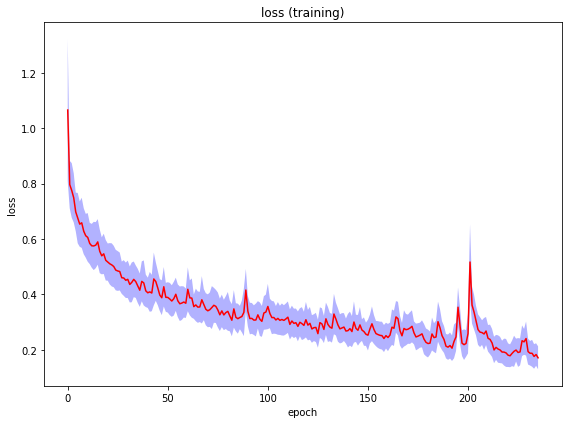

In [18]:
print('[plot the training loss]')
print('') 
plot_curve_error(total_loss_mean_train[:236], total_loss_std_train[:236], 'epoch', 'loss', 'loss (training)')

[plot the testing loss]



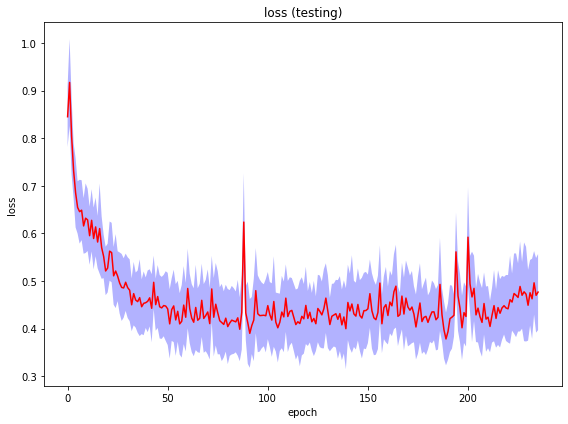

In [19]:
print('[plot the testing loss]')
print('') 
plot_curve_error(total_loss_mean_test[:236], total_loss_std_test[:236], 'epoch', 'loss', 'loss (testing)')

[plot the traning accuracy]



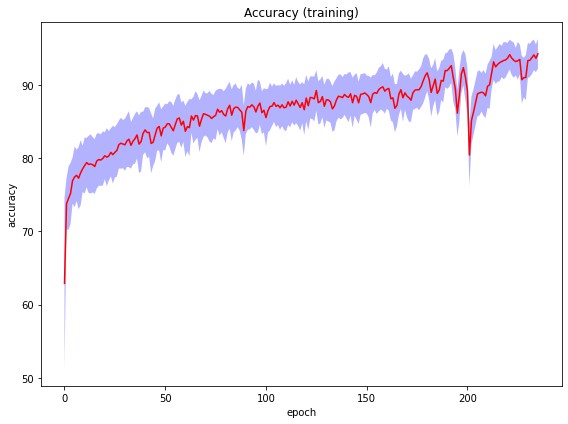

In [22]:
print('[plot the traning accuracy]') 
print('') 
plot_curve_error(accuracy_mean_train[:236], accuracy_std_train[:236], 'epoch', 'accuracy', 'Accuracy (training)')

[plot the testing accuracy]



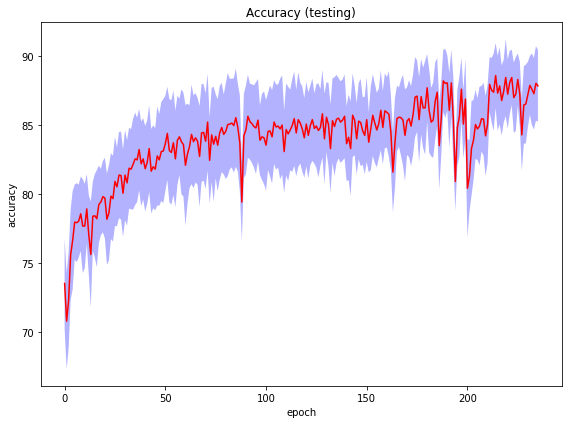

In [23]:
print('[plot the testing accuracy]') 
print('') 
plot_curve_error(accuracy_mean_test[:236], accuracy_std_test[:236], 'epoch', 'accuracy', 'Accuracy (testing)')